In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

%matplotlib inline

The first step of the analysis is to make some assumptions about the DDS engine we'll be working with here. 

I'm setting a stretch goal of a 100MHz clock frequency/sample rate for the DDS, and an accumulator depth of 32 bits. 

That gives us a frequency resolution of:

$F_{res} = \frac{F_{clock}}{2^{N}} = \frac{100 MHz}{2^{32}} = ~0.02 Hz$

To save some brain sweat, I'm going to write two quick functions to interchange frequencies and tuning words:

In [9]:
# Returns the frequency tuning word for a desired frequency output 
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def freq_to_tuning(freq_out, sample_rate=100000000, acc_depth=32):
    return int((freq_out * (2**acc_depth))/sample_rate)

# Returns the frequency output for a given frequency tuning word
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def tuning_to_freq(tuning_word, sample_rate=100000000, acc_depth=32):
    return (tuning_word * sample_rate) / float(2 ** acc_depth)

Note, too, that these aren't perfect exchanges. There's some quantization error inherent in a digital system - that's the frequency resolution we calculated a second ago. You can see this by just jumping back and forth between formats, and noting the error between the conversions:

In [10]:
freq = 2822400
tuning = freq_to_tuning(freq)
freq_actual = tuning_to_freq(tuning)

error = ((freq_actual - freq)/freq) * 100
print(f"{freq} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

2822400 Hz signal: 0x0739b024
2822399.977594614 Hz signal: 0x0739b024 (-7.938416231246222e-07)


There's also error introduced in the way that Python truncates rather than rounds when converting between `float` and `int`. Astute readers have likely noted that the _next_ value, `0x0739b025`, actually produces a lower-error signal. Tuning code `0x0739b025` produces an output of 2822400.0008776784 Hz rather than the original 2822399.977594614 Hz: 

In [11]:
tuning = tuning + 1
freq_actual = tuning_to_freq(tuning)
error = ((freq_actual - freq)/freq) * 100
print(f"{freq_actual} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

2822400.0008776784 Hz signal: 0x0739b025
2822400.0008776784 Hz signal: 0x0739b025 (3.109688188483656e-08)


Worth noting: a typical uncompensated quartz crystal will vary around 25-50ppm in frequency when installed into an oscillator circuit. Whether or not this is something you need to lose sleep over is specific to your application. Odds are this is a totally appropriate amount of jitter for your frequency synthesis application. (If it's not, then you're probably working on something like an atomic clock. If you _are_ working on an atomic clock, and you're reading this page for advice on timing jitter, you've got bigger problems on your plate than frequency synthesis.) Ethernet phys and Bluetooth ICs the world over happily run with oscillator reference tolerances in the 25ppm range, and reliably serve up phone calls, Spotify streams, and cat photos to people every day. 

Anywhoozles: using that rather gnarly 32 bit number `0x0739b025` as our genesis point, we can generate a sample phase accumulator output using the following code block:

Text(0.5, 1.0, 'DDS Output')

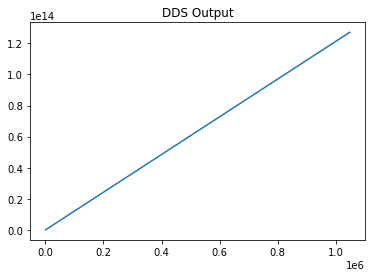

In [12]:
# Generates a phase accumulator output for a given tuning word
phase = [ 0 ]
while len(phase) < (2**20):
    phase.append(phase[-1] + tuning)

plt.plot(phase)
plt.title("DDS Output")

OK, great. The chart goes up, and to the right. (The business unit will be _ecstatic_.) Eventually, it's going to just roll over to zero, and keep on counting up. That's not a big deal! This is a *phase* accumulator; phase wraps around from $2\pi$ back to zero. As long as `0x00000000` corresponds to 0 degrees phase, you're in the clear! 

The phase accumulator has a couple more fortunate features for us besidse phase wrapping. At some point, we're gonna need to convert _phase_ to _amplitude_. The easiest (and also fastest) way to do this is with a lookup table, or a simple ROM. If phase wasn't a parameter that rolled over, we'd be up shit creek without an infinite memory paddle. It's also complete and absolute overkill to use all the possible addresses generated by a 32 bit phase accumulator. That'd produce a ~4GB lookup table of sine values! 

The accumulator instead gets _truncated_ down to its most significant bits - in this case, the 12 MSBs:

In [13]:
df_phase = pd.DataFrame(zip(phase, [tuning] * len(phase)), columns=['phase', 'tuning'])
df_phase['phase_trunc'] = np.bitwise_and(df_phase['phase'], 0xFFC00000)
df_phase['phase_trunc'] = np.right_shift(df_phase['phase_trunc'], 20)

A short function allows us to generate sine lookup ROMs really quickly:

In [14]:
# Generate a rom table of a sine wave with signed integers 
def generate_sin_rom(bits, rom_depth):
    # Subtract 1 from bit depth for signed data (msb is sign bit)
    amplitude = 2**(bit_depth-1)
    sin_rom = [int(amplitude * math.sin(a/rom_depth * 2 * math.pi)) for a in range(rom_depth)]
    return(sin_rom)

bit_depth = 12
rom_size = 4096
sin_rom = generate_sin_rom(bit_depth, rom_size)

...and a lambda function allows us to turn this into a sine wave, toot sweet.

<AxesSubplot:>

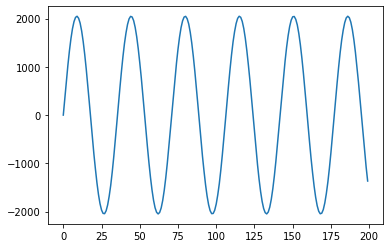

In [15]:
# Lambda function serves as phase-to-amplitude converter
df_phase['dds_out'] = df_phase['phase_trunc'].apply(lambda x: sin_rom[x])
df_phase['dds_out'][:200].plot()

No big deal if you didn't follow all of that. Here's the truncated phase, the sine output, and the frequency spectrum of that output sine signal:

In [28]:
data_fft = np.fft.fft(df_phase['dds_out'])
frequencies = np.abs(data_fft)
freq_scale = frequencies * 2 / len(frequencies)
db_freqs = freq_scale / float(2**(bit_depth-1))
db_freqs

array([2.84984708e-07, 3.95200198e-08, 5.42963749e-08, ...,
       3.13374552e-08, 5.42963749e-08, 3.95200198e-08])

<ipython-input-37-87ec83c138a2>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3,1,3)
<ipython-input-37-87ec83c138a2>:30: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,fft_index)


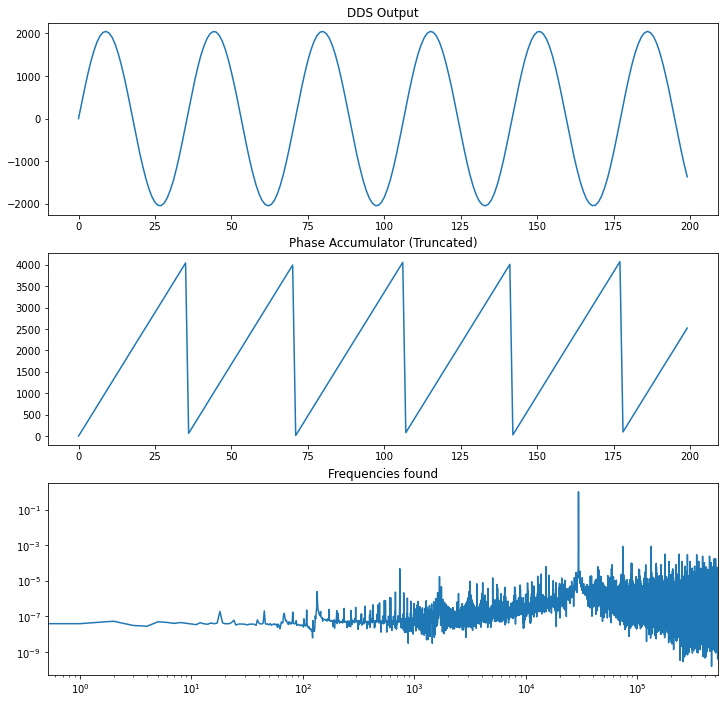

29595

In [37]:
data_fft = np.fft.fft(df_phase['dds_out'])
frequencies = np.abs(data_fft)
freq_scale = frequencies * 2 / len(frequencies)
db_freqs = freq_scale / float(2048)

## There is some kind of problem with log scaling
# db_freqs = 20 * np.log10(db_freqs)

plot_len = 200

fig = plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(df_phase['dds_out'][:plot_len])
plt.title("DDS Output")

plt.subplot(3,1,2)
plt.plot(df_phase['phase_trunc'][:plot_len])
plt.title("Phase Accumulator (Truncated)")

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(3,1,3)
ax = fig.add_subplot(3,1,3)
ax.set_yscale('log')

fft_index = int(len(frequencies)/2) # Half of the FFT output 
#fft_index = 5000
plt.plot(db_freqs[:fft_index])
 
plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()


A few thoughts on this frequency spectrum:

* It's really clear what our fundamental/main output frequency is. That peak at 2.822MHz towers above the rest by about 40dB (or 2 orders of magnitude if you're not into the whole dB thing). 
* That's not really a _great_ signal to noise ratio in terms of digital synthesis. There are a few regular tones that you can see peeking out of the noise 
* Going to a log scale on the x axis (frequency axis) shows that the high frequency noise is really getting out of control on this signal. 


So what can we do about all of this excess noise, and these tones degrading our SNR? (Or, as the cool kids in applied math land like to call it, "SFDR": "spurious free dynamic range". That's the official name for the ratio of your desired signal's intensity to your undesirable harmonics' intensity.) There's a few more neat tricks on how to get around this, including:

* Increasing the bit depth of your sin rom
* Increasing the ROM depth of your sin rom
* Dithering
* Taylor series correction

Dope Links for Cool Cats 

https://www.xilinx.com/support/documentation/ip_documentation/dds.pdf

http://www.ieee.li/pdf/essay/dds.pdf 



<ipython-input-46-8da0496134f9>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,1)


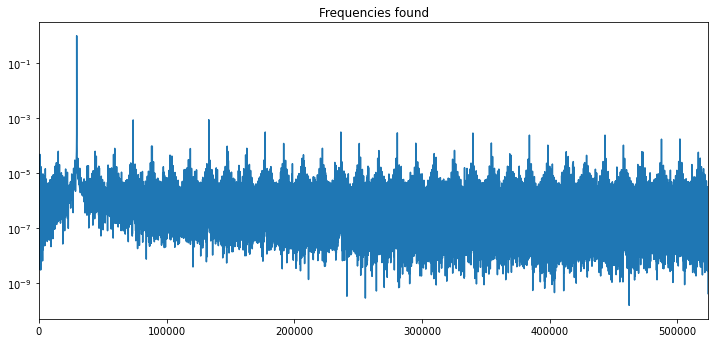

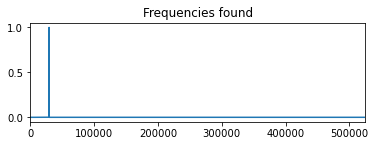

In [46]:
fig = plt.figure(figsize=(12,12))
fft_index = int(len(frequencies)/2) # Half of the FFT output 

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(2,1,1)
ax = fig.add_subplot(2,1,1)
ax.set_yscale('log')

plt.plot(db_freqs[:fft_index])
plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_yscale('log')
ax.set_xscale('log')

plt.plot(db_freqs[:fft_index])
plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()


In [74]:
data = [] 
with open('../output_results.txt') as f:
    for line in f:
        data.append(line.strip().split(','))
        
# Converts testbench data to ints
data = [data[0]] + [[int(j) for j in i] for i in data[1:]]

FileNotFoundError: [Errno 2] No such file or directory: '../output_results.txt'

In [4]:
df = pd.DataFrame(data[1:], columns=data[0])
df

,addr_tb,data_tb
0,0,0
1,1,0
2,2,0
3,3,0
4,4,3
...,...,...
499995,8475,-219
499996,8476,-222
499997,8477,-222
499998,8478,-222


<AxesSubplot:>

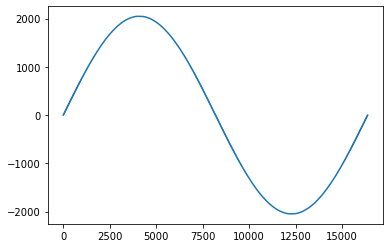

In [8]:
import matplotlib.pyplot as plt
df['data_tb'][:(4*4096)].plot()

In [30]:
import matplotlib.pyplot as plt
sp = np.fft.fft(df['data_tb'], n=8192)
sp

array([10668416.           +0.j        , -3562884.2774399 -1366.34907475j,
        -711589.69589066 -545.7825682j , ...,
        -305337.60550223 +351.28667048j,  -711589.69589066 +545.7825682j ,
       -3562884.2774399 +1366.34907475j])

In [25]:
len(sp)

1024

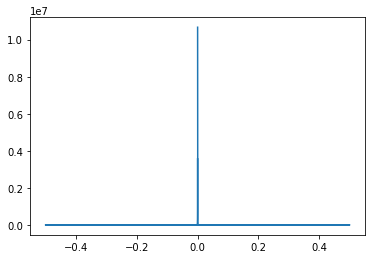

In [34]:
freq = np.fft.fftfreq(len(sp))
plt.plot(freq, np.abs(sp))
plt.show()

/Users/nreilly/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:>

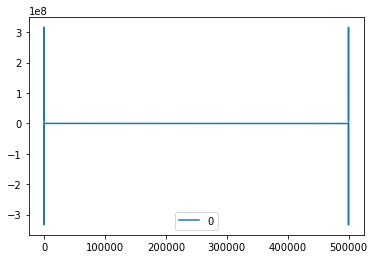

In [46]:
fft_data = np.fft.fft(df['data_tb'])

pd.DataFrame(fft_data).plot()

In [20]:
print(pd.__version__)

1.2.4
